In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from mlxtend.frequent_patterns import apriori, association_rules #Import training model

pd.set_option('display.max_columns',None)

In [2]:
def import_package(depth: int, is_jupyter: bool):
    if is_jupyter is False:
        current_dir = os.path.dirname(os.path.abspath(__file__))
    else:
        current_dir = os.getcwd()

    parent_dir = current_dir
    while depth > 0:
        depth -= 1
        parent_dir = os.path.dirname(parent_dir)
    print(current_dir)
    print(parent_dir)
    sys.path.insert(0, parent_dir)

import_package(1, True)

/Users/nguyenhuyhai/20212/applyStatistic/midterm_project/instacart-market-basket-analysis
/Users/nguyenhuyhai/20212/applyStatistic/midterm_project


In [3]:
departments= pd.read_csv('departments.csv')
order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__train = pd.read_csv('order_products__train.csv')
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
sample_submission = pd.read_csv('sample_submission.csv')

In [4]:
# departments #Mabe we do not use this

In [5]:
# order_products__prior #2

In [6]:
# order_products__train #2

In [7]:
# orders #1

In [8]:
# products

In [9]:
# sample_submission

## Explain

In [10]:
"""
Goal:
The dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.
For each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order

-Table: orders
    +order_id: id of order (PK)
    +user_id: id of user
    +eval_set: Type of customer (prior, train, test)
        In this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. 
        ->So the last order of the user has been taken out and divided into train and test sets

        ++prior: prior orders dataset  
        ++train: train dataset of the last order
        ++test: test dataset of the last order

    +order_number: number of order
    +order_dow: order in day of week(from 0 -> 6) <But we don't know which values represent which day
    +order_hour_of_day: order in  hour of a day (0->23) 
    +days_since_prior_order: Day that people buy again

-Table: order_products__train: information about train order
    +order_id: id of order
    +product_id: id of product
    +PK: order_id + product_id
    +add_to_cart_order: number of product of that order that people add to cart(buy)
    +reordered: Is that order 

-Table: order_product_prior: information about prior order

-Table: product: product information
    product_id(PK)
    product_name
    aisle_id
    department_id
"""

"\nGoal:\nThe dataset is anonymized and contains a sample of over 3 million grocery orders from more than 200,000 Instacart users.\nFor each user, 4 and 100 of their orders are given, with the sequence of products purchased in each order\n\n-Table: orders\n    +order_id: id of order (PK)\n    +user_id: id of user\n    +eval_set: Type of customer (prior, train, test)\n        In this dataset, 4 to 100 orders of a customer are given (we will look at this later) and we need to predict the products that will be re-ordered. \n        ->So the last order of the user has been taken out and divided into train and test sets\n\n        ++prior: prior orders dataset  \n        ++train: train dataset of the last order\n        ++test: test dataset of the last order\n\n    +order_number: number of order\n    +order_dow: order in day of week(from 0 -> 6) <But we don't know which values represent which day\n    +order_hour_of_day: order in  hour of a day (0->23) \n    +days_since_prior_order: Day tha

## EDA

In [11]:
orders

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
...,...,...,...,...,...,...,...
3421078,2266710,206209,prior,10,5,18,29.0
3421079,1854736,206209,prior,11,4,10,30.0
3421080,626363,206209,prior,12,1,12,18.0
3421081,2977660,206209,prior,13,1,12,7.0


In [12]:
for i in range(len(orders.columns)): #Check the percetntage of Nan
    missing_data = orders[orders.columns[i]].isna().sum()
    perc = missing_data / len(orders[orders.columns[i]]) * 100
    print(str(orders.columns[i])+' has missing entries: %d, which is %.2f percent of total' % (missing_data, perc))

order_id has missing entries: 0, which is 0.00 percent of total
user_id has missing entries: 0, which is 0.00 percent of total
eval_set has missing entries: 0, which is 0.00 percent of total
order_number has missing entries: 0, which is 0.00 percent of total
order_dow has missing entries: 0, which is 0.00 percent of total
order_hour_of_day has missing entries: 0, which is 0.00 percent of total
days_since_prior_order has missing entries: 206209, which is 6.03 percent of total


In [13]:
color = sns.color_palette()


/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


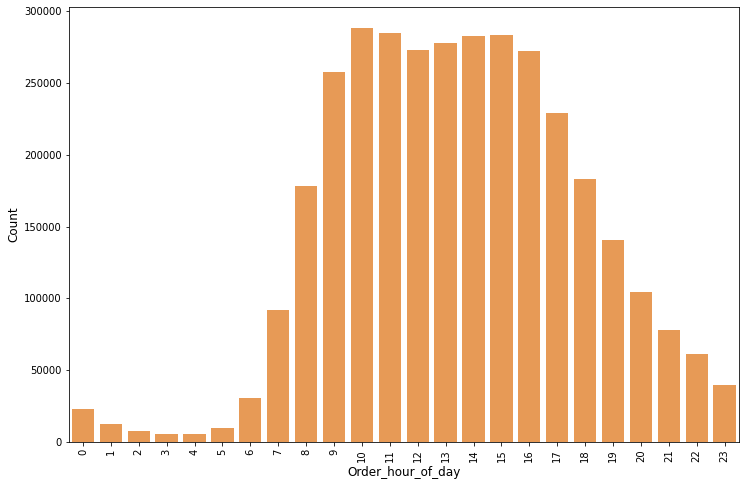

In [14]:
cnt_srs = orders.order_hour_of_day.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Order_hour_of_day', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [15]:
#Most often order from 8 -> 18

/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


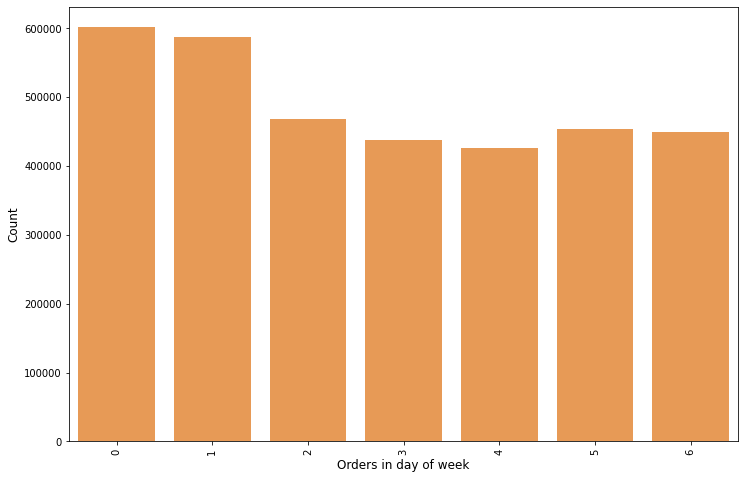

In [16]:
cnt_srs = orders.order_dow.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Orders in day of week', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [17]:
# Day 0 and Day 1 is max

/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


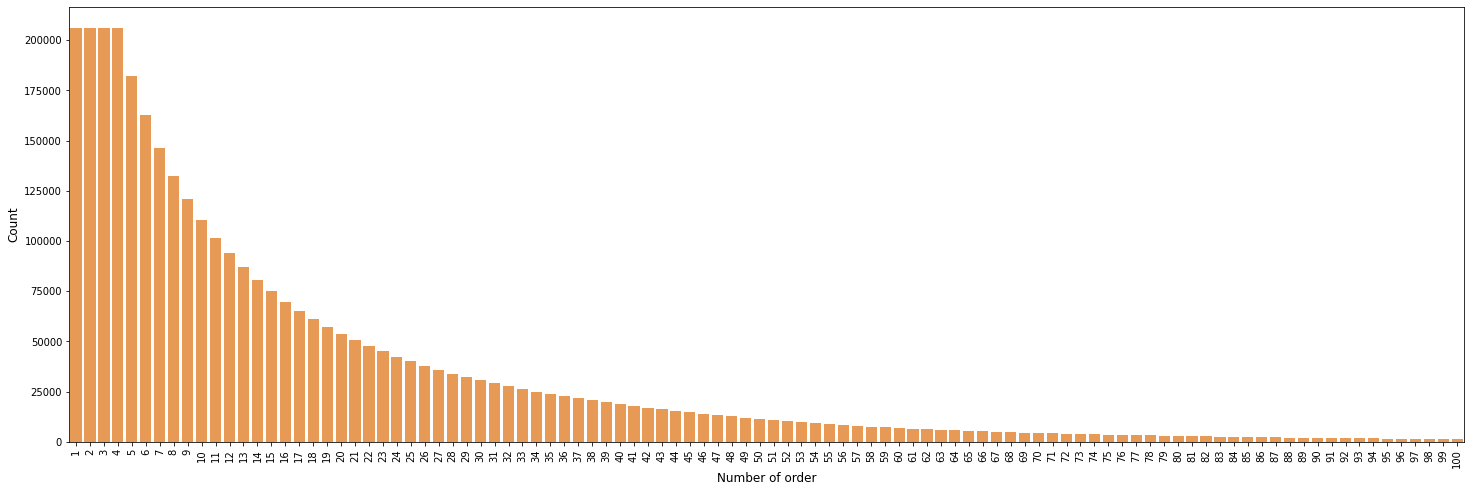

In [18]:
cnt_srs = orders.order_number.value_counts()

plt.figure(figsize=(25,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [19]:
#There always at least 3 prior orders

/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


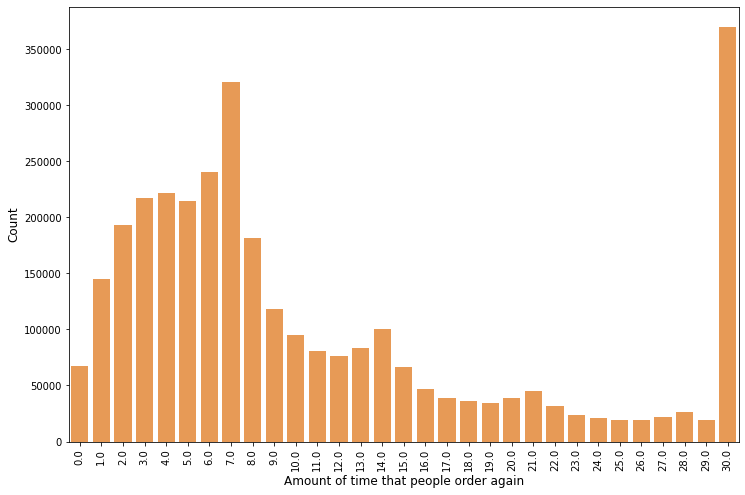

In [20]:
cnt_srs = orders.days_since_prior_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Amount of time that people order again', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

People tends to buy things after 1 week, small peak at 14, 21, 28 days

### order_products__prior

In [21]:
order_products__prior

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
...,...,...,...,...
32434484,3421083,39678,6,1
32434485,3421083,11352,7,0
32434486,3421083,4600,8,0
32434487,3421083,24852,9,1


In [22]:
# percentage of re-orders in prior set #
order_products__prior.reordered.sum() / len(order_products__prior)

0.5896974667922161

In [23]:
def encode_units(x): #decode unit
    if x <= 0:
        return 0
    if x >= 1: 
        return 1 

In [24]:

# percentage of no re-orders products
grouped_df = order_products__prior.groupby("order_id")["reordered"].aggregate("sum").reset_index() #groupby order_id by sum
grouped_df.reordered = grouped_df.reordered.map(encode_units) #apply mapping encode_units that reordered product is 1, non reordered product is 0

grouped_df.reordered.value_counts() / len(grouped_df) #calculate percentage of no re-orders products

1    0.879151
0    0.120849
Name: reordered, dtype: float64

/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


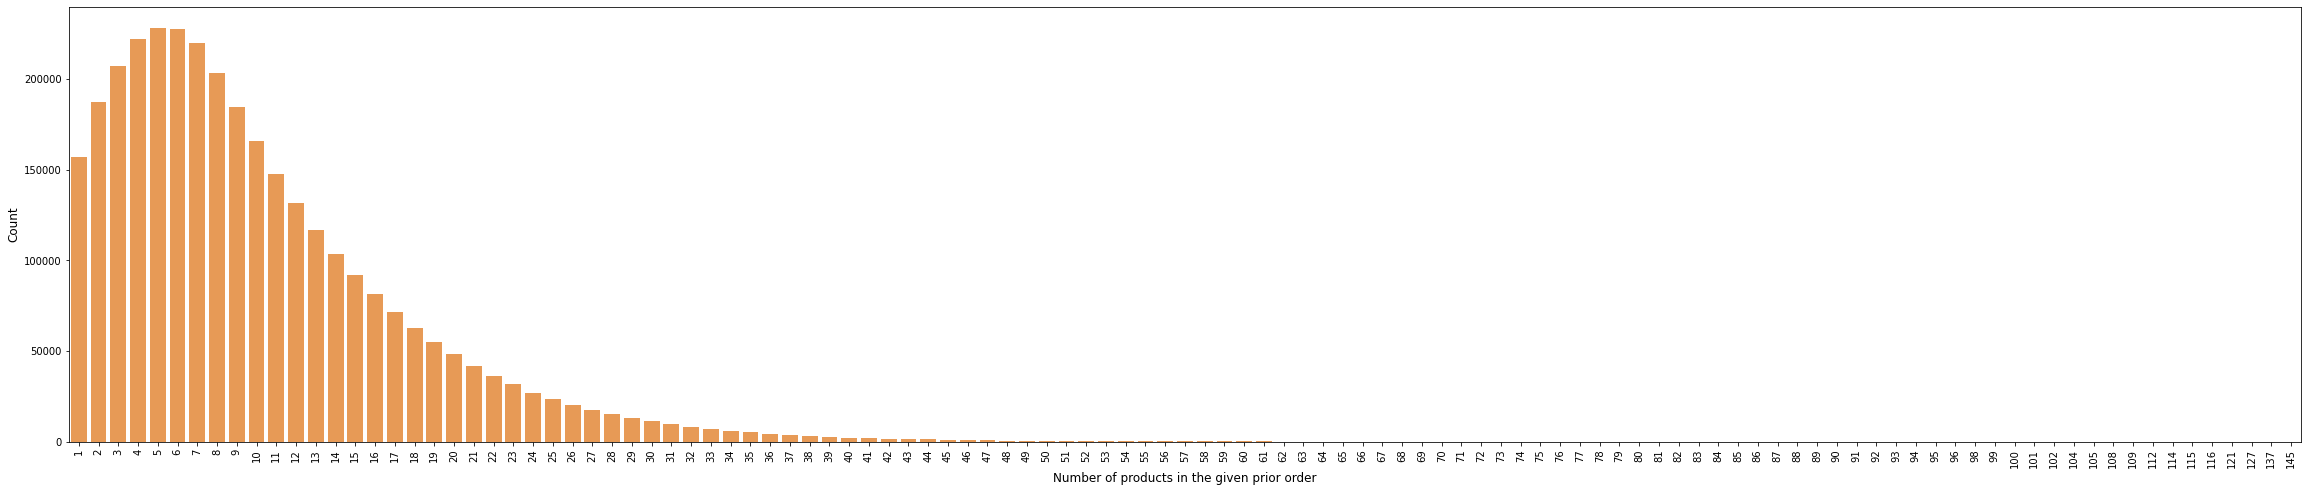

In [25]:
grouped_df = order_products__prior.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index() # groupby order_id by max

cnt_srs = grouped_df.add_to_cart_order.value_counts() #count the appearance of each element

plt.figure(figsize=(40,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of products in the given prior order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

In [26]:
order_products__train

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
...,...,...,...,...
1384612,3421063,14233,3,1
1384613,3421063,35548,4,1
1384614,3421070,35951,1,1
1384615,3421070,16953,2,1


In [27]:
# percentage of re-orders in prior set #
order_products__train.reordered.sum() / len(order_products__train)

0.5985944127509629

In [28]:

# percentage of no re-orders products
grouped_df = order_products__train.groupby("order_id")["reordered"].aggregate("sum").reset_index() #groupby order_id by sum
grouped_df.reordered = grouped_df.reordered.map(encode_units) #apply mapping encode_units that reordered product is 1, non reordered product is 0

grouped_df.reordered.value_counts() / len(grouped_df) #calculate percentage of no re-orders products

1    0.93444
0    0.06556
Name: reordered, dtype: float64

/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


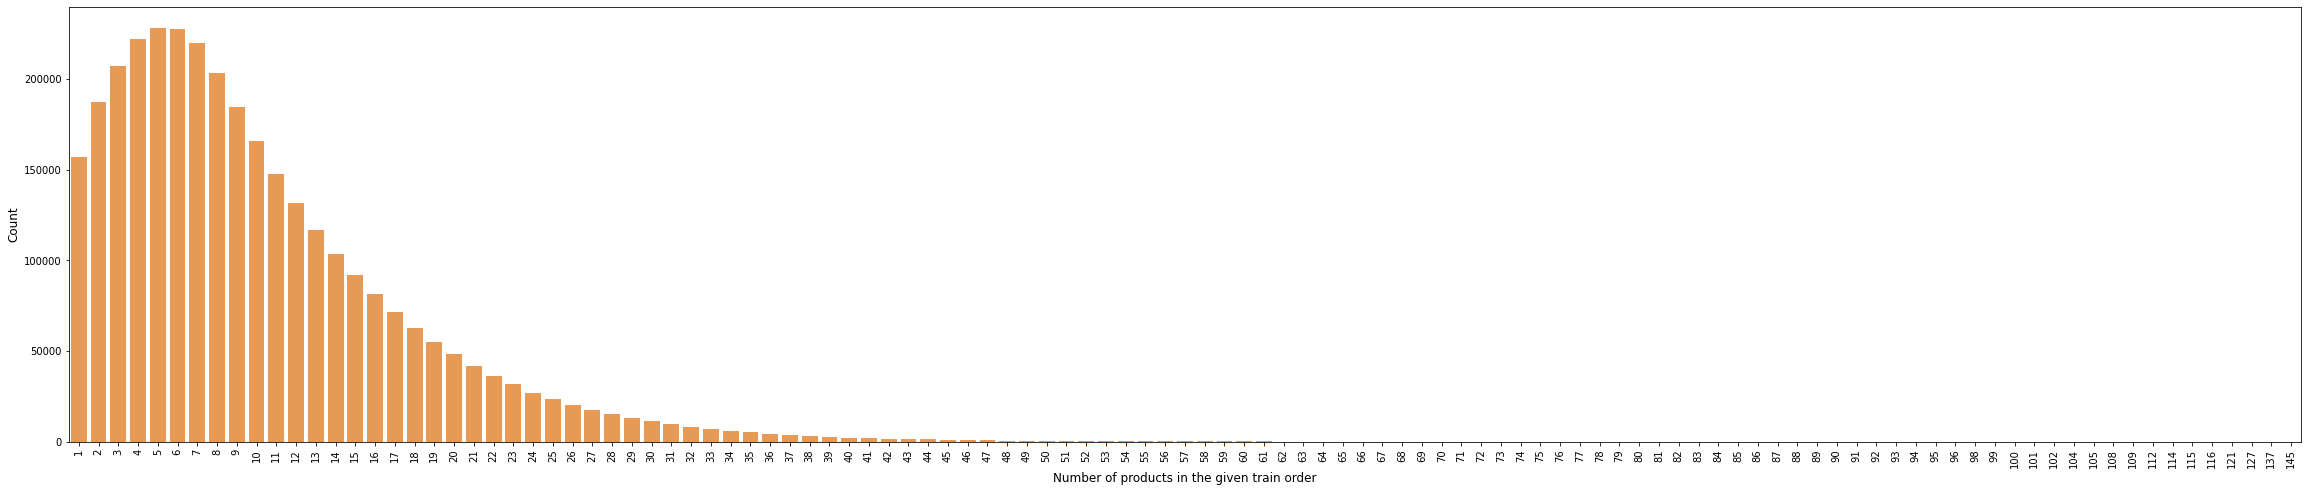

In [29]:
grouped_df = order_products__prior.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()

cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(40,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8, color=color[1])
plt.ylabel('Count', fontsize=12)
plt.xlabel('Number of products in the given train order', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

## Apriori

In [30]:
order_products__train = pd.merge(order_products__train, products, on='product_id', how='left')



In [31]:
order_products__train

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,Organic Celery Hearts,83,4
3,1,49683,4,0,Cucumber Kirby,83,4
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15
...,...,...,...,...,...,...,...
1384612,3421063,14233,3,1,Natural Artesian Water,115,7
1384613,3421063,35548,4,1,Twice Baked Potatoes,13,20
1384614,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16
1384615,3421070,16953,2,1,Creamy Peanut Butter,88,13


In [32]:
order_products__train.product_name.value_counts()

Banana                                           18726
Bag of Organic Bananas                           15480
Organic Strawberries                             10894
Organic Baby Spinach                              9784
Large Lemon                                       8135
                                                 ...  
Red Raspberry Syrup                                  1
Organic Montebello Penne Rigate Italian Pasta        1
ULTRACLEAN™ Arctic Mint Mouth Wash                   1
Torrential Tropical Punch                            1
Plain Golden Toasted Bread Crumbs                    1
Name: product_name, Length: 39123, dtype: int64

In [33]:
ranking_product = order_products__train.product_name.value_counts().to_frame()

In [34]:
# ranking_product.rename(columns = {'product_name':'new_index'},
#           inplace = True)
ranking_product = ranking_product.reset_index()

In [35]:
ranking_product

,index,product_name
0,Banana,18726
1,Bag of Organic Bananas,15480
2,Organic Strawberries,10894
3,Organic Baby Spinach,9784
4,Large Lemon,8135
...,...,...
39118,Red Raspberry Syrup,1
39119,Organic Montebello Penne Rigate Italian Pasta,1
39120,ULTRACLEAN™ Arctic Mint Mouth Wash,1
39121,Torrential Tropical Punch,1


In [36]:
ranking_product.rename(columns = {'index':'product_name', 'product_name': 'count'}, inplace = True)

In [37]:
ranking_product = ranking_product[(ranking_product['count'] >= 1500) & (ranking_product['count'] < 3500)]
ranking_product = ranking_product.reset_index()
ranking_product.drop('index', axis =1, inplace= True)

In [38]:
ranking_product

,product_name,count
0,Sparkling Water Grapefruit,3359
1,Raspberries,3279
2,Organic Fuji Apple,3257
3,Small Hass Avocado,3103
4,Broccoli Crown,2932
...,...,...
56,Organic Black Beans,1576
57,2% Reduced Fat Milk,1540
58,Organic Reduced Fat 2% Milk,1535
59,Grape White/Green Seedless,1527


In [39]:
ranking_product.style.background_gradient(cmap='Greens') #Initial visualizations


,product_name,count
0,Sparkling Water Grapefruit,3359
1,Raspberries,3279
2,Organic Fuji Apple,3257
3,Small Hass Avocado,3103
4,Broccoli Crown,2932
5,Organic Baby Arugula,2923
6,Red Peppers,2905
7,Organic Large Extra Fancy Fuji Apple,2891
8,Original Hummus,2858
9,Organic Blackberries,2843


In [40]:
ranking_product["Tree_map"] = "Tree_map" #To have a same origin

fig = px.treemap(ranking_product, path = ['Tree_map', "product_name"], values = 'count', 
                color = ranking_product["count"], hover_data = ['product_name'], color_continuous_scale = 'Greens', )
fig.show() #Create a tree map

/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.

/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/plotly/io/_renderers.py:395: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [41]:
order_products__train

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,1,49302,1,1,Bulgarian Yogurt,120,16
1,1,11109,2,1,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16
2,1,10246,3,0,Organic Celery Hearts,83,4
3,1,49683,4,0,Cucumber Kirby,83,4
4,1,43633,5,1,Lightly Smoked Sardines in Olive Oil,95,15
...,...,...,...,...,...,...,...
1384612,3421063,14233,3,1,Natural Artesian Water,115,7
1384613,3421063,35548,4,1,Twice Baked Potatoes,13,20
1384614,3421070,35951,1,1,Organic Unsweetened Almond Milk,91,16
1384615,3421070,16953,2,1,Creamy Peanut Butter,88,13


In [42]:
# top30_product = ranking_product.head(30)
# list_of_top30 = top30_product.product_name.tolist()
# order_products__train = order_products__train[order_products__train.product_name.isin(list_of_top30)] #with just 30 top feature


#With 1500-2500 occurance feature:
product_list = ranking_product.product_name.tolist()
order_products__train = order_products__train[order_products__train.product_name.isin(product_list)]




In [43]:
drop_columns = ['reordered', 'product_id', 'add_to_cart_order', 'aisle_id','department_id']

order_products__train.drop(drop_columns, axis = 1, inplace = True)


/var/folders/hh/60pmh2sx0f3bb29z6_vx_9tm0000gn/T/ipykernel_37931/1601007373.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [44]:
order_products = order_products__train[order_products__train.order_id.isin(order_products__train.order_id.value_counts().loc[lambda x: x >= 3].index)]

In [45]:
order_products = order_products.reset_index()

In [46]:
order_products.drop('index', axis  =1, inplace = True)

In [47]:
order_products

,order_id,product_name
0,36,Spring Water
1,36,Organic Half & Half
2,36,Organic Garnet Sweet Potato (Yam)
3,98,Organic Unsweetened Almond Milk
4,98,Uncured Genoa Salami
...,...,...
68860,3420998,Large Alfresco Eggs
68861,3420998,Organic Peeled Whole Baby Carrots
68862,3420998,Apple Honeycrisp Organic
68863,3420998,Organic Tomato Cluster


In [48]:
one_hot = pd.get_dummies(order_products['product_name']) #Create dummies
order_products.drop('product_name', inplace=True, axis=1) #Delete duplicate, inplace=true to permanently delete, axis=1 to delete column
df = order_products.join(one_hot) #Merge dummy table vs dataset
df

,order_id,100% Whole Wheat Bread,2% Reduced Fat Milk,Apple Honeycrisp Organic,Blueberries,Boneless Skinless Chicken Breasts,Broccoli Crown,Bunched Cilantro,Carrots,Cucumber Kirby,Extra Virgin Olive Oil,Fresh Cauliflower,Garlic,Grape White/Green Seedless,Grated Parmesan,Green Bell Pepper,Half & Half,Hass Avocado,Hass Avocados,Jalapeno Peppers,Large Alfresco Eggs,Lime Sparkling Water,Michigan Organic Kale,Orange Bell Pepper,Organic Baby Arugula,Organic Banana,Organic Black Beans,Organic Blackberries,Organic Broccoli,Organic Carrot Bunch,Organic D'Anjou Pears,Organic Fuji Apple,Organic Gala Apples,Organic Garnet Sweet Potato (Yam),Organic Ginger Root,Organic Grade A Free Range Large Brown Eggs,Organic Granny Smith Apple,Organic Half & Half,Organic Italian Parsley Bunch,Organic Kiwi,Organic Lacinato (Dinosaur) Kale,Organic Large Extra Fancy Fuji Apple,Organic Navel Orange,Organic Peeled Whole Baby Carrots,Organic Red Bell Pepper,Organic Reduced Fat 2% Milk,Organic Small Bunch Celery,Organic Tomato Cluster,Organic Unsweetened Almond Milk,Organic Whole String Cheese,Original Hummus,Raspberries,Red Peppers,Red Vine Tomato,Roma Tomato,Small Hass Avocado,Soda,Sparkling Natural Mineral Water,Sparkling Water Grapefruit,Spring Water,Uncured Genoa Salami,Unsweetened Almondmilk
0,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,36,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
4,98,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68860,3420998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
68861,3420998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
68862,3420998,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
68863,3420998,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [49]:
records = df.groupby(["order_id"])[product_list[:]].apply(sum) #Create transactions
#If a person buy many products in a day, so all of this products are considered to be a transaction
records = records.reset_index()[product_list]
baskets = records
records.head(10)

,Sparkling Water Grapefruit,Raspberries,Organic Fuji Apple,Small Hass Avocado,Broccoli Crown,Organic Baby Arugula,Red Peppers,Organic Large Extra Fancy Fuji Apple,Original Hummus,Organic Blackberries,Organic Gala Apples,Fresh Cauliflower,Organic Half & Half,Michigan Organic Kale,Organic Small Bunch Celery,Organic Garnet Sweet Potato (Yam),Organic Tomato Cluster,Green Bell Pepper,Carrots,Organic Peeled Whole Baby Carrots,Half & Half,Cucumber Kirby,Organic Italian Parsley Bunch,Organic Red Bell Pepper,Organic Granny Smith Apple,Organic Banana,Blueberries,100% Whole Wheat Bread,Hass Avocados,Apple Honeycrisp Organic,Red Vine Tomato,Spring Water,Organic Unsweetened Almond Milk,Unsweetened Almondmilk,Boneless Skinless Chicken Breasts,Extra Virgin Olive Oil,Organic Ginger Root,Organic Whole String Cheese,Organic Navel Orange,Lime Sparkling Water,Roma Tomato,Garlic,Bunched Cilantro,Jalapeno Peppers,Large Alfresco Eggs,Organic D'Anjou Pears,Organic Kiwi,Orange Bell Pepper,Sparkling Natural Mineral Water,Uncured Genoa Salami,Organic Grade A Free Range Large Brown Eggs,Organic Lacinato (Dinosaur) Kale,Organic Carrot Bunch,Grated Parmesan,Organic Broccoli,Hass Avocado,Organic Black Beans,2% Reduced Fat Milk,Organic Reduced Fat 2% Milk,Grape White/Green Seedless,Soda
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [50]:
records

,Sparkling Water Grapefruit,Raspberries,Organic Fuji Apple,Small Hass Avocado,Broccoli Crown,Organic Baby Arugula,Red Peppers,Organic Large Extra Fancy Fuji Apple,Original Hummus,Organic Blackberries,Organic Gala Apples,Fresh Cauliflower,Organic Half & Half,Michigan Organic Kale,Organic Small Bunch Celery,Organic Garnet Sweet Potato (Yam),Organic Tomato Cluster,Green Bell Pepper,Carrots,Organic Peeled Whole Baby Carrots,Half & Half,Cucumber Kirby,Organic Italian Parsley Bunch,Organic Red Bell Pepper,Organic Granny Smith Apple,Organic Banana,Blueberries,100% Whole Wheat Bread,Hass Avocados,Apple Honeycrisp Organic,Red Vine Tomato,Spring Water,Organic Unsweetened Almond Milk,Unsweetened Almondmilk,Boneless Skinless Chicken Breasts,Extra Virgin Olive Oil,Organic Ginger Root,Organic Whole String Cheese,Organic Navel Orange,Lime Sparkling Water,Roma Tomato,Garlic,Bunched Cilantro,Jalapeno Peppers,Large Alfresco Eggs,Organic D'Anjou Pears,Organic Kiwi,Orange Bell Pepper,Sparkling Natural Mineral Water,Uncured Genoa Salami,Organic Grade A Free Range Large Brown Eggs,Organic Lacinato (Dinosaur) Kale,Organic Carrot Bunch,Grated Parmesan,Organic Broccoli,Hass Avocado,Organic Black Beans,2% Reduced Fat Milk,Organic Reduced Fat 2% Milk,Grape White/Green Seedless,Soda
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17661,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17662,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17664,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [51]:
def encode_units(x):
    if x <= 0:
        return 0
    if x >= 1: 
        return 1 

datasets = records.applymap(encode_units)
datasets #Encode 0 & 1 format

,Sparkling Water Grapefruit,Raspberries,Organic Fuji Apple,Small Hass Avocado,Broccoli Crown,Organic Baby Arugula,Red Peppers,Organic Large Extra Fancy Fuji Apple,Original Hummus,Organic Blackberries,Organic Gala Apples,Fresh Cauliflower,Organic Half & Half,Michigan Organic Kale,Organic Small Bunch Celery,Organic Garnet Sweet Potato (Yam),Organic Tomato Cluster,Green Bell Pepper,Carrots,Organic Peeled Whole Baby Carrots,Half & Half,Cucumber Kirby,Organic Italian Parsley Bunch,Organic Red Bell Pepper,Organic Granny Smith Apple,Organic Banana,Blueberries,100% Whole Wheat Bread,Hass Avocados,Apple Honeycrisp Organic,Red Vine Tomato,Spring Water,Organic Unsweetened Almond Milk,Unsweetened Almondmilk,Boneless Skinless Chicken Breasts,Extra Virgin Olive Oil,Organic Ginger Root,Organic Whole String Cheese,Organic Navel Orange,Lime Sparkling Water,Roma Tomato,Garlic,Bunched Cilantro,Jalapeno Peppers,Large Alfresco Eggs,Organic D'Anjou Pears,Organic Kiwi,Orange Bell Pepper,Sparkling Natural Mineral Water,Uncured Genoa Salami,Organic Grade A Free Range Large Brown Eggs,Organic Lacinato (Dinosaur) Kale,Organic Carrot Bunch,Grated Parmesan,Organic Broccoli,Hass Avocado,Organic Black Beans,2% Reduced Fat Milk,Organic Reduced Fat 2% Milk,Grape White/Green Seedless,Soda
0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17661,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
17662,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
17663,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
17664,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [52]:
frequent_itemsets = apriori(datasets, min_support=0.0003, use_colnames=True) # Extracting the most frequest itemsets via Mlxtend.
frequent_itemsets


/Users/nguyenhuyhai/opt/anaconda3/envs/Sea/lib/python3.10/site-packages/mlxtend/frequent_patterns/fpcommon.py:111: DeprecationWarning:

DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type



,support,itemsets
0,0.079135,(Sparkling Water Grapefruit)
1,0.062153,(Raspberries)
2,0.081682,(Organic Fuji Apple)
3,0.090060,(Small Hass Avocado)
4,0.090966,(Broccoli Crown)
...,...,...
7970,0.000396,"(Organic Small Bunch Celery, Organic Ginger Ro..."
7971,0.000340,"(Organic Kiwi, Jalapeno Peppers, Organic Small..."
7972,0.000340,"(Green Bell Pepper, Boneless Skinless Chicken ..."
7973,0.000396,"(Green Bell Pepper, Bunched Cilantro, Jalapeno..."


In [53]:
# The length column has been added to increase ease of filtering.
frequent_itemsets['length'] = frequent_itemsets['itemsets'].apply(lambda x: len(x))
frequent_itemsets

,support,itemsets,length
0,0.079135,(Sparkling Water Grapefruit),1
1,0.062153,(Raspberries),1
2,0.081682,(Organic Fuji Apple),1
3,0.090060,(Small Hass Avocado),1
4,0.090966,(Broccoli Crown),1
...,...,...,...
7970,0.000396,"(Organic Small Bunch Celery, Organic Ginger Ro...",4
7971,0.000340,"(Organic Kiwi, Jalapeno Peppers, Organic Small...",4
7972,0.000340,"(Green Bell Pepper, Boneless Skinless Chicken ...",4
7973,0.000396,"(Green Bell Pepper, Bunched Cilantro, Jalapeno...",4


In [54]:
#  We set our metric as "Lift" to define whether antecedents & consequents are dependent our not
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1.2)
rules["antecedents_length"] = rules["antecedents"].apply(lambda x: len(x))
rules["consequents_length"] = rules["consequents"].apply(lambda x: len(x))
rules.sort_values("lift", ascending=False).head(20)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
2060,"(Raspberries, Hass Avocados)",(Soda),0.004528,0.003227,0.000340,0.075000,23.244737,0.000325,1.077593,2,1
2065,(Soda),"(Raspberries, Hass Avocados)",0.003227,0.004528,0.000340,0.105263,23.244737,0.000325,1.112586,1,2
20044,"(Organic Blackberries, Blueberries)","(Small Hass Avocado, Raspberries)",0.007076,0.004472,0.000623,0.088000,19.678582,0.000591,1.091588,2,2
20049,"(Small Hass Avocado, Raspberries)","(Organic Blackberries, Blueberries)",0.004472,0.007076,0.000623,0.139241,19.678582,0.000591,1.153544,2,2
20718,"(Jalapeno Peppers, Organic Granny Smith Apple)","(Organic Kiwi, Organic Small Bunch Celery)",0.003000,0.005830,0.000340,0.113208,19.416743,0.000322,1.121085,2,2
20715,"(Organic Kiwi, Organic Small Bunch Celery)","(Jalapeno Peppers, Organic Granny Smith Apple)",0.005830,0.003000,0.000340,0.058252,19.416743,0.000322,1.058670,2,2
20034,"(Sparkling Water Grapefruit, Organic Half & Half)","(Lime Sparkling Water, Organic Whole String Ch...",0.005830,0.003340,0.000340,0.058252,17.442159,0.000320,1.058309,2,2
20031,"(Lime Sparkling Water, Organic Whole String Ch...","(Sparkling Water Grapefruit, Organic Half & Half)",0.003340,0.005830,0.000340,0.101695,17.442159,0.000320,1.106717,2,2
20731,"(Boneless Skinless Chicken Breasts, Organic Re...","(Green Bell Pepper, Red Vine Tomato)",0.003736,0.005661,0.000340,0.090909,16.060000,0.000318,1.093773,2,2
20730,"(Green Bell Pepper, Red Vine Tomato)","(Boneless Skinless Chicken Breasts, Organic Re...",0.005661,0.003736,0.000340,0.060000,16.060000,0.000318,1.059855,2,2


In [55]:
pd.set_option('display.max_rows',500)

In [58]:
# Sort values based on confidence
rules.sort_values("lift", ascending=False)

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedents_length,consequents_length
2060,"(Raspberries, Hass Avocados)",(Soda),0.004528,0.003227,0.000340,0.075000,23.244737,0.000325,1.077593,2,1
2065,(Soda),"(Raspberries, Hass Avocados)",0.003227,0.004528,0.000340,0.105263,23.244737,0.000325,1.112586,1,2
20044,"(Organic Blackberries, Blueberries)","(Small Hass Avocado, Raspberries)",0.007076,0.004472,0.000623,0.088000,19.678582,0.000591,1.091588,2,2
20049,"(Small Hass Avocado, Raspberries)","(Organic Blackberries, Blueberries)",0.004472,0.007076,0.000623,0.139241,19.678582,0.000591,1.153544,2,2
20718,"(Jalapeno Peppers, Organic Granny Smith Apple)","(Organic Kiwi, Organic Small Bunch Celery)",0.003000,0.005830,0.000340,0.113208,19.416743,0.000322,1.121085,2,2
...,...,...,...,...,...,...,...,...,...,...,...
242,(Grape White/Green Seedless),(Organic Granny Smith Apple),0.045681,0.077437,0.004245,0.092937,1.200162,0.000708,1.017088,1,1
5373,(Unsweetened Almondmilk),"(Organic Baby Arugula, Organic Garnet Sweet Po...",0.054342,0.007812,0.000509,0.009375,1.200136,0.000085,1.001578,1,2
3722,(Unsweetened Almondmilk),"(Organic Whole String Cheese, Small Hass Avocado)",0.054342,0.005208,0.000340,0.006250,1.200136,0.000057,1.001049,1,2
5370,"(Organic Baby Arugula, Organic Garnet Sweet Po...",(Unsweetened Almondmilk),0.007812,0.054342,0.000509,0.065217,1.200136,0.000085,1.011634,2,1
